In [1]:
#!pip install -q datasets peft==0.3.0 levenshtein==0.26.1 accelerate==1.2.1 evaluate==0.4.0 transformers==4.45.2
# torch==2.5.1+cu118
# torchaudio==2.5.1+cu118
# torchdata==0.5.1
# torchvision==0.20.1+cu118
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Fine Tuning BERT Model using PEFT-LORA

 ### Setup

In [ ]:
import sys
sys.path.append("../")
from torch import nn
import pandas as pd
from transformers import TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report
import seaborn as sea
import time
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import nltk
import evaluate
import numpy as np 
from peft import LoraConfig, get_peft_model, TaskType
from transformers import TrainingArguments, Trainer
from peft import PeftModel
from accelerate import Accelerator
import torch
from transformers import BertTokenizer, BertForSequenceClassification, DataCollatorWithPadding
import time
import torch
import gc
import os
if torch.cuda.is_available():
   dev = "cuda:0"
else:
   dev = "cpu"

# Libraries options
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device(dev)
print('Using {}'.format(device))
gc.collect()
torch.cuda.empty_cache()   
torch.cuda.empty_cache()
nltk.download('stopwords')
nltk.download('punkt')
pd.options.display.max_rows = 999
pd.set_option('max_colwidth', 1000)
current_device = Accelerator().process_index
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, current_device)

np.random.seed(123)
torch.manual_seed(123)

###  Data Access

In [5]:
dataframe = pd.read_parquet('../Datasets/pre_processed_dataframes/clean_df.parquet')
len(dataframe)

5070

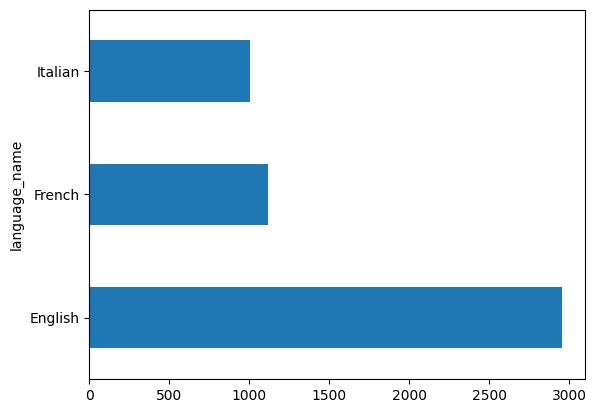

In [6]:
ax = dataframe['language_name'].value_counts().plot(kind='barh')

In [7]:
dataframe = dataframe[dataframe['language_name'] == 'English'].copy()
valid_categories = ['Sports', 'Entertainment', 'Covid']
dataframe = dataframe[dataframe['Category'].isin(valid_categories)]
len(dataframe)

1033

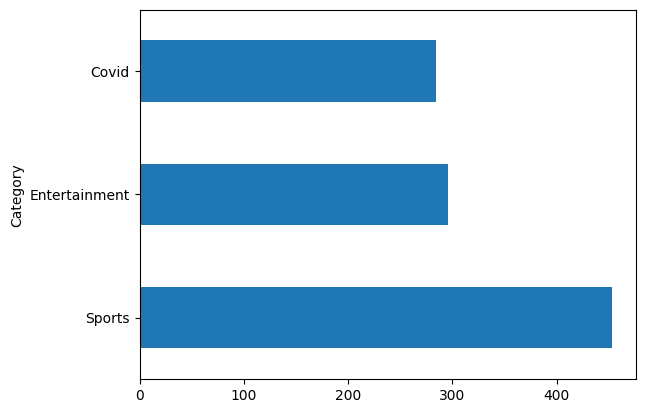

In [8]:
ax = dataframe['Category'].value_counts().plot(kind='barh')

In [9]:
len(dataframe)

1033

### Training and Validation Data

In [10]:
df_train, df_test = train_test_split(dataframe, test_size=0.4, stratify=dataframe['Category'])
df_valid, df_test = train_test_split(df_test, test_size=0.5)
len(dataframe), len(df_train), len(df_valid), len(df_test)

(1033, 619, 207, 207)

### Model Fine-Tuning

**Parameter Efficient Fine-Tuning (PEFT)**

Performing **Parameter Efficient Fine-Tuning (PEFT)** fine-tuning as opposed to "full fine-tuning". PEFT is a form of instruction fine-tuning that is much more efficient than full fine-tuning - with comparable evaluation results as you will see soon. 

PEFT is a generic term that includes **Low-Rank Adaptation (LoRA)** and prompt tuning. LoRA, at a very high level, allows the user to fine-tune their model using fewer compute resources (in some cases, a single GPU). After fine-tuning for a specific task, use case, or tenant with LoRA, the result is that the original LLM remains unchanged and a newly-trained “LoRA adapter” emerges. This LoRA adapter is much, much smaller than the original LLM - on the order of a single-digit % of the original LLM size (MBs vs GBs).  

That said, at inference time, the LoRA adapter needs to be reunited and combined with its original LLM to serve the inference request.  The benefit, however, is that many LoRA adapters can re-use the original LLM which reduces overall memory requirements when serving multiple tasks and use cases.

####  Access to Hugging Face Model

In [11]:
model_path='google-bert/bert-base-multilingual-uncased'

In [12]:
num_labels = len(df_train['Category'].unique())
num_labels

3

In [13]:
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=num_labels).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

In [15]:
print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 167358723
all model parameters: 167358723
percentage of trainable model parameters: 100.00%


####  Prepare Data

In [16]:
max_length = 512

In [17]:
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

label_mapping = {category: index for index, category in enumerate(dataframe['Category'].unique())}

label = 'label'
df_train[label] = df_train['Category'].apply(lambda x: label_mapping[x])
df_valid[label] = df_valid['Category'].apply(lambda x: label_mapping[x])
df_test[label] = df_test['Category'].apply(lambda x: label_mapping[x])

model.config.id2label = label_mapping
model.config.label2id = {v: k for k, v in label_mapping.items()}

column_name = 'cleaned_description'
train_dataset, train_label, = list(df_train[column_name]), list(df_train[label].values)
valid_dataset, valid_label, = list(df_valid[column_name]), list(df_valid[label].values)
test_dataset, test_label, = list(df_test[column_name]), list(df_test[label].values)

train_dataset = Dataset.from_dict({"text": train_dataset, "label": train_label})
valid_dataset = Dataset.from_dict({"text": valid_dataset, "label": valid_label})
test_dataset = Dataset.from_dict({"text": test_dataset, "label": test_label})

def preprocess_function(examples):
    return tokenizer(examples["text"], padding='max_length', truncation=True,  max_length=max_length)

train_dataset = train_dataset.map(preprocess_function, batched=True, batch_size=512)
valid_dataset = valid_dataset.map(preprocess_function, batched=True, batch_size=512)
test_dataset = test_dataset.map(preprocess_function, batched=True, batch_size=512)

len(train_dataset), len(valid_dataset), len(test_dataset)

Map: 100%|██████████| 207/207 [00:00<00:00, 2602.09 examples/s]


(619, 207, 207)

#### Fine-Tuning the Model

In [18]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [19]:
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")        
        # classes weights
        weights = [1.0, 1.0, 1.0]
        class_weights = torch.tensor(weights, device=logits.device)
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))        
        return (loss, outputs) if return_outputs else loss

out_dir ='./fine_tuning_news'
training_args = TrainingArguments(output_dir=out_dir,
                                   eval_strategy="steps",
                                   overwrite_output_dir=True,
                                   save_total_limit=1,
                                   run_name='fine_tuning',
                                   num_train_epochs=10,                                   
                                   report_to="none",#no wandb api log
                                   auto_find_batch_size=True,                                                                      
                                   push_to_hub=False,
                                     # Parameters for early stopping
                                    load_best_model_at_end=True,
                                    save_total_limit=1,
                                    metric_for_best_model="eval_loss",
                                    greater_is_better=False)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [20]:
torch.cuda.empty_cache()

In [21]:
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics      
)
trainer_start_time = time.time()
trainer.train()
trainer_total_time = (time.time() - trainer_start_time)/60

 16%|█▌        | 500/3100 [02:26<12:48,  3.38it/s]

{'loss': 0.9893, 'grad_norm': 12.495787620544434, 'learning_rate': 4.1935483870967746e-05, 'epoch': 1.61}


                                                  
 16%|█▌        | 500/3100 [02:33<12:48,  3.38it/s]

{'eval_loss': 0.8509621620178223, 'eval_accuracy': 0.5942028985507246, 'eval_runtime': 7.1474, 'eval_samples_per_second': 28.962, 'eval_steps_per_second': 3.638, 'epoch': 1.61}


 32%|███▏      | 1000/3100 [05:09<10:22,  3.37it/s] 

{'loss': 0.8275, 'grad_norm': 11.668805122375488, 'learning_rate': 3.387096774193548e-05, 'epoch': 3.23}


                                                   
 32%|███▏      | 1000/3100 [05:16<10:22,  3.37it/s]

{'eval_loss': 2.069755792617798, 'eval_accuracy': 0.5942028985507246, 'eval_runtime': 7.1838, 'eval_samples_per_second': 28.815, 'eval_steps_per_second': 3.619, 'epoch': 3.23}


 48%|████▊     | 1500/3100 [07:47<07:55,  3.36it/s]  

{'loss': 1.0069, 'grad_norm': 7.720119476318359, 'learning_rate': 2.5806451612903226e-05, 'epoch': 4.84}


                                                   
 48%|████▊     | 1500/3100 [07:54<07:55,  3.36it/s]

{'eval_loss': 1.2931580543518066, 'eval_accuracy': 0.27053140096618356, 'eval_runtime': 7.1822, 'eval_samples_per_second': 28.821, 'eval_steps_per_second': 3.62, 'epoch': 4.84}


 65%|██████▍   | 2000/3100 [10:25<05:26,  3.37it/s]  

{'loss': 0.7675, 'grad_norm': 0.15506120026111603, 'learning_rate': 1.774193548387097e-05, 'epoch': 6.45}


                                                   
 65%|██████▍   | 2000/3100 [10:32<05:26,  3.37it/s]

{'eval_loss': 0.9806039333343506, 'eval_accuracy': 0.8067632850241546, 'eval_runtime': 7.2154, 'eval_samples_per_second': 28.689, 'eval_steps_per_second': 3.603, 'epoch': 6.45}


 81%|████████  | 2500/3100 [13:04<02:58,  3.35it/s]

{'loss': 0.8777, 'grad_norm': 0.26012519001960754, 'learning_rate': 9.67741935483871e-06, 'epoch': 8.06}


                                                   
 81%|████████  | 2500/3100 [13:11<02:58,  3.35it/s]

{'eval_loss': 0.7653775215148926, 'eval_accuracy': 0.642512077294686, 'eval_runtime': 7.1986, 'eval_samples_per_second': 28.756, 'eval_steps_per_second': 3.612, 'epoch': 8.06}


 97%|█████████▋| 3000/3100 [15:42<00:29,  3.35it/s]

{'loss': 0.7304, 'grad_norm': 51.155635833740234, 'learning_rate': 1.6129032258064516e-06, 'epoch': 9.68}


                                                   
 97%|█████████▋| 3000/3100 [15:49<00:29,  3.35it/s]

{'eval_loss': 0.7590185403823853, 'eval_accuracy': 0.8357487922705314, 'eval_runtime': 7.2176, 'eval_samples_per_second': 28.68, 'eval_steps_per_second': 3.602, 'epoch': 9.68}


100%|██████████| 3100/3100 [16:24<00:00,  3.15it/s]

{'train_runtime': 984.618, 'train_samples_per_second': 6.287, 'train_steps_per_second': 3.148, 'train_loss': 0.8491401155533329, 'epoch': 10.0}


In [23]:
trainer.evaluate()

30it [00:10,  2.84it/s]                        


{'eval_loss': 0.7798380255699158,
 'eval_accuracy': 0.8260869565217391,
 'eval_runtime': 7.155,
 'eval_samples_per_second': 28.931,
 'eval_steps_per_second': 3.634,
 'epoch': 10.0}

In [24]:
predictions = trainer.predict(test_dataset)
label_ids = predictions.predictions.argmax(-1)
labels_names = [model.config.label2id[id] for id in label_ids]
df_test['predictions - fine tuning'] = label_ids
df_test['Category (automatic fine tuning)'] = labels_names

100%|██████████| 26/26 [00:06<00:00,  3.78it/s]


In [ ]:
y_true_ids = df_test['label'].values
y_pred_ids = df_test['predictions - fine tuning'].values
y_true_labels = df_test['Category'].values
y_pred_labels = df_test['Category (automatic fine tuning)'].values

trainer_precision = np.round(precision_score(y_true_ids, y_pred_ids, average='macro', zero_division=0), 3)
trainer_recall = np.round(recall_score(y_true_ids, y_pred_ids, average='macro', zero_division=0), 3)
trainer_f1 = np.round(f1_score(y_true_ids, y_pred_ids, average='macro', zero_division=0), 3)


Precision: 0.829
Recall: 0.826
F1 Score: 0.827
               precision    recall  f1-score   support

        Covid       0.75      0.81      0.78        68
Entertainment       0.87      0.84      0.85        56
       Sports       0.86      0.83      0.85        83

     accuracy                           0.83       207
    macro avg       0.83      0.83      0.83       207
 weighted avg       0.83      0.83      0.83       207



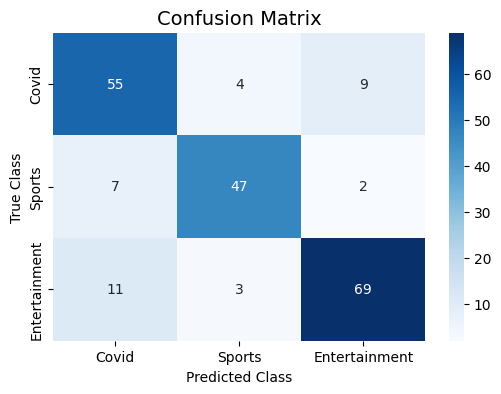

In [30]:
print(f"Precision: {trainer_precision}")
print(f"Recall: {trainer_recall}")
print(f"F1 Score: {trainer_f1}")
print(classification_report(y_true_labels, y_pred_labels, zero_division=0))

target_names = model.config.id2label.keys()
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(6, 4))
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [31]:
data = []
data.append(['Fine Tuning (Training)', trainer_f1, trainer_precision, trainer_recall, trainer_total_time])            
data

[['Fine Tuning (Training)', 0.827, 0.829, 0.826, 16.48309491078059]]

##### PEFT/LORA Configuration

In [32]:
lora_config = LoraConfig(
    r=4, # dimensions
    lora_alpha=6,
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.TOKEN_CLS
)
peft_model = get_peft_model(model, lora_config)
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 152070
all model parameters: 167508486
percentage of trainable model parameters: 0.09%


##### Training the Adapter

In [33]:
output_dir = f'./peft/{str(int(time.time()))}'

In [ ]:
peft_training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="steps",
    overwrite_output_dir=True,
    save_total_limit=1,
    run_name='fine_tuning',
    num_train_epochs=10,    
    report_to="none", #no wandb api log
    auto_find_batch_size=True,                                                                      
    push_to_hub=False
    )

peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    )

peft_trainer_start_time = time.time()
peft_trainer.train()
peft_trainer_total_time = (time.time() - peft_trainer_start_time)/60

In [38]:
peft_trainer.evaluate()

100%|██████████| 26/26 [00:07<00:00,  3.64it/s]


{'eval_loss': 0.5676062107086182,
 'eval_accuracy': 0.855072463768116,
 'eval_runtime': 7.4412,
 'eval_samples_per_second': 27.818,
 'eval_steps_per_second': 3.494,
 'epoch': 10.0}

##### Evaluation

In [ ]:
predictions = peft_trainer.predict(test_dataset)

Precision: 0.831
Recall: 0.828
F1 Score: 0.829
               precision    recall  f1-score   support

        Covid       0.84      0.76      0.80        68
Entertainment       0.82      0.84      0.83        56
       Sports       0.83      0.88      0.85        83

     accuracy                           0.83       207
    macro avg       0.83      0.83      0.83       207
 weighted avg       0.83      0.83      0.83       207



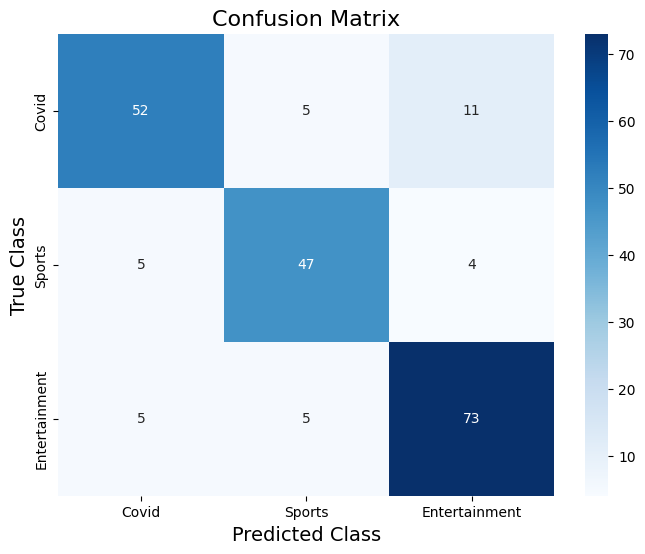

In [40]:
label_ids = predictions.predictions.argmax(-1)
labels_names = [model.config.label2id[id] for id in label_ids]
df_test['predictions - peft'] = label_ids
df_test['Category (automatic - peft)'] = labels_names

y_true_ids = df_test['label'].values
y_pred_ids = df_test['predictions - peft'].values

y_true_labels = df_test['Category'].values
y_pred_labels = df_test['Category (automatic - peft)'].values

peft_precision = np.round(precision_score(y_true_ids, y_pred_ids, average='macro', zero_division=0), 3)
peft_recall = np.round(recall_score(y_true_ids, y_pred_ids, average='macro', zero_division=0), 3)
peft_f1 = np.round(f1_score(y_true_ids, y_pred_ids, average='macro', zero_division=0), 3)

print(f"Precision: {peft_precision}")
print(f"Recall: {peft_recall}")
print(f"F1 Score: {peft_f1}")
print(classification_report(y_true_labels, y_pred_labels, zero_division=0))

target_names = model.config.id2label.keys()
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('True Class', fontsize=14)
plt.show()


In [41]:
data.append(['PEFT (Training)', peft_f1, peft_precision, peft_recall, peft_trainer_total_time])            
data

[['Fine Tuning (Training)', 0.827, 0.829, 0.826, 16.48309491078059],
 ['PEFT (Training)', 0.829, 0.831, 0.828, 9.567769372463227]]

In [42]:
print('Total time training fine tuning model = ', trainer_total_time)
print('Total time training peft fine tuning model = ', peft_trainer_total_time)


Total time training fine tuning model =  16.48309491078059
Total time training peft fine tuning model =  9.567769372463227


##### Save the Model

In [43]:
peft_model_path="./peft-clf-checkpoint-local"
peft_trainer.model.save_pretrained(peft_model_path)

 ##### Access Fine Tuning Model

In [50]:
loaded_peft_model = PeftModel.from_pretrained(model, 
                                    peft_model_path,                                       
                                    torch_dtype=torch.bfloat16,
                                    is_trainable=False,
                                    )

loaded_peft_model.load_adapter(peft_model_path, 'adapter_config')
loaded_peft_model.set_adapter('adapter_config')

/home/carina/anaconda3/envs/hugging_face_env/lib/python3.9/site-packages/peft/peft_model.py:372: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adapters_weights = torch.load(

In [46]:
print(print_number_of_trainable_model_parameters(loaded_peft_model))

trainable model parameters: 0
all model parameters: 167655942
percentage of trainable model parameters: 0.00%


In [69]:
validation_sentences = valid_dataset['text']

In [70]:
inputs = tokenizer(
    validation_sentences,
    padding=True,
    truncation=True,
    max_length=max_length,
    return_tensors="pt"
)
with torch.no_grad():
    outputs = loaded_peft_model(**inputs)
    logits = outputs.logits

In [72]:
label_ids = torch.argmax(logits, dim=-1).tolist()
labels_names = [model.config.label2id[id] for id in label_ids]
df_valid['predictions - peft'] = label_ids
df_valid['Category (automatic - peft)'] = labels_names

y_true_ids = df_valid['label'].values
y_pred_ids = df_valid['predictions - peft'].values

y_true_labels = df_valid['Category'].values
y_pred_labels = df_valid['Category (automatic - peft)'].values

Precision: 0.815
Recall: 0.826
F1 Score: 0.813
               precision    recall  f1-score   support

        Covid       0.59      0.80      0.68        46
Entertainment       0.92      0.86      0.89        63
       Sports       0.94      0.82      0.87        98

     accuracy                           0.83       207
    macro avg       0.81      0.83      0.81       207
 weighted avg       0.85      0.83      0.83       207



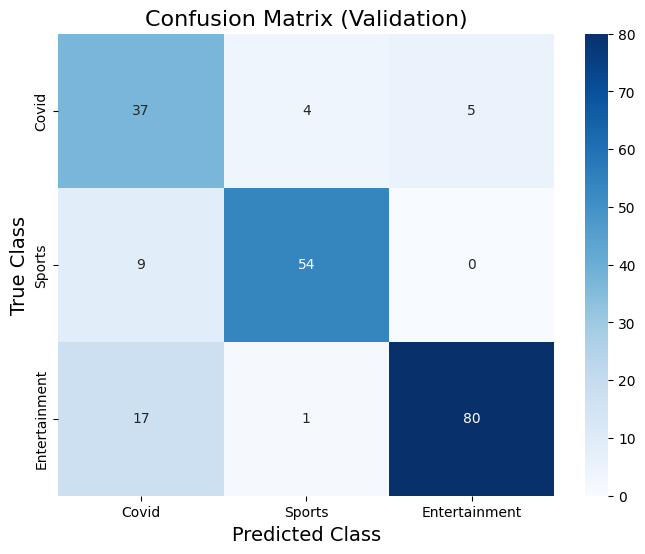

In [76]:
peft_precision_validation = np.round(precision_score(y_true_ids, y_pred_ids, average='macro', zero_division=0), 3)
peft_recall_validation = np.round(recall_score(y_true_ids, y_pred_ids, average='macro', zero_division=0), 3)
peft_f1_validation = np.round(f1_score(y_true_ids, y_pred_ids, average='macro', zero_division=0), 3)

print(f"Precision: {peft_precision_validation}")
print(f"Recall: {peft_recall_validation}")
print(f"F1 Score: {peft_f1_validation}")
print(classification_report(y_true_labels, y_pred_labels, zero_division=0))

target_names = model.config.id2label.keys()
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (Validation)', fontsize=16)
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('True Class', fontsize=14)
plt.show()


In [77]:
data.append(['PEFT (Validation)', peft_f1_validation, peft_precision_validation, peft_recall_validation, 0])            
data

[['Fine Tuning (Training)', 0.827, 0.829, 0.826, 16.48309491078059],
 ['PEFT (Training)', 0.829, 0.831, 0.828, 9.567769372463227],
 ['PEFT (Validation)', 0.813, 0.815, 0.826, 0]]

In [113]:
metrics_df = pd.DataFrame(data, columns=['Strategy', 'F1', 'Precision', 'Recall', 'Training Time'])           
metrics_df = metrics_df[metrics_df['Strategy'] != 'PEFT (Validation)'].copy()

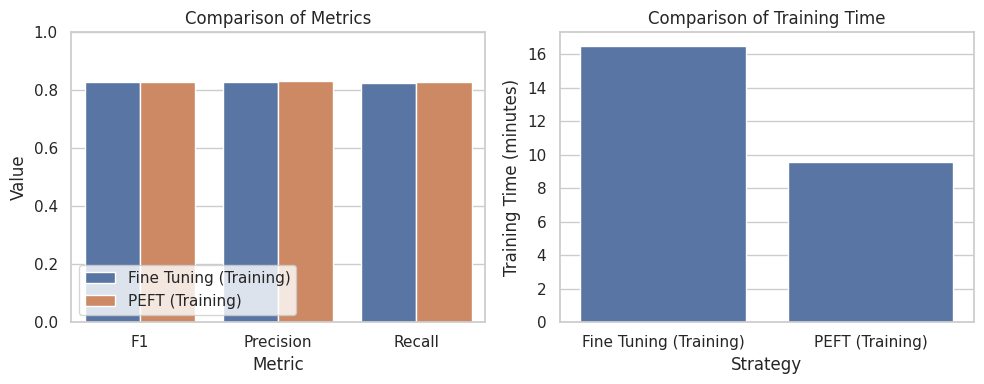

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

df = metrics_df[['Strategy', 'F1', 'Precision', 'Recall']].melt(id_vars='Strategy', var_name='Metric', value_name='Value')
sea.barplot(data=df, x='Metric', y='Value', hue='Strategy', ax=axes[0])
axes[0].legend(loc='lower left')
axes[0].set_ylim(0, 1)
axes[0].set_title('Comparison of Metrics')
sea.barplot(data=metrics_df, x='Strategy', y='Training Time', ax=axes[1])
axes[1].set_title('Comparison of Training Time')
axes[1].set_ylabel('Training Time (minutes)')
plt.tight_layout()
plt.show()